For Collab

In [ ]:
!git clone https://github.com/GerardTho/Deep_image_prior_inpainting.git

In [ ]:
cd Deep_image_prior_inpainting

In [1]:
import torch
import numpy as np

import utils
from model.EncoderDecoder import EncoderDecoder
from model.EncoderDecoderSkipConcat import EncoderDecoderSkipConcat

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [3]:
INPUT = 'noise'
input_depth = 3
LR = 0.01
num_iter = 5000
param_noise = False
show_every = 100
figsize = 5
reg_noise_std = 0
OPTIMIZER = 'adam'
model_selection = "EncoderDecoderSkipConcat"

In [4]:
img_path  = 'data/vase.png'
mask_path = 'data/vase_mask.png'
img_pil, img_np = utils.get_image(img_path)
img_mask_pil, img_mask_np = utils.get_image(mask_path)
img_mask_pil = utils.crop_image(img_mask_pil)
img_pil      = utils.crop_image(img_pil)
img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)

In [5]:
if model_selection == "EncoderDecoder":
    model = EncoderDecoder(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],).to(device)
elif model_selection == "EncoderDecoderSkipConcat":
    model = EncoderDecoderSkipConcat(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        n_skip=[0,0,0,4,4,4],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],
                        k_skip=[1,1,1,1,1,1],).to(device)

c:\Users\wande\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [6]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in model.parameters())
print ('Number of params: %d' % s)

img_var = torch.from_numpy(img_np).reshape(-1, img_np.shape[0], img_np.shape[1], img_np.shape[2]).to(device)
mask_var = torch.from_numpy(img_mask_np).reshape(-1, img_mask_np.shape[0], img_mask_np.shape[1], img_mask_np.shape[2]).to(device)

# Loss
mse = torch.nn.MSELoss()

net_input = utils.generate_noise(input_depth, img_np.shape[1:]).to(device)

Number of params: 3186499


In [ ]:
def optimize(parameters, LR, num_iter):
  optimizer = torch.optim.Adam(parameters, lr=LR)
  for j in range(num_iter):
    optimizer.zero_grad()

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    optimizer.step()

    print ('Iteration %05d    Loss %f' % (j, total_loss.item()), '\r', end='')
    if j % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = [x for x in model.parameters()]
optimize(p, LR, num_iter)

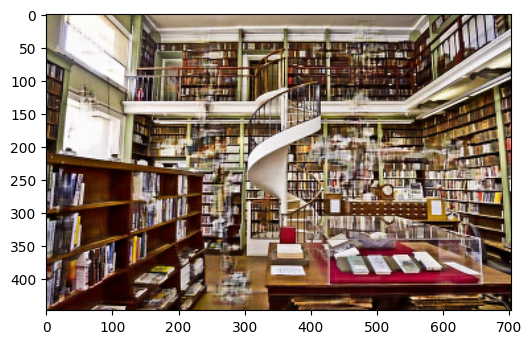

In [ ]:
out_np = model(net_input).detach().cpu().numpy()[0]
utils.plot_image_grid([out_np], factor=5);